# Libraries

In [109]:
%cd -q library
%run common.ipy
%cd -q ..

from library.fns import get_raw_data, fix_col_names
from library.cleaner import Cleaner
from sklearn.dummy import DummyClassifier
import pickle

# EDA

In [38]:
X_train_raw, X_test_raw, y_train, y_test = get_raw_data()
X_train_raw_col_fix = fix_col_names(X_train_raw)
X_test_raw_col_fix = fix_col_names(X_test_raw)
c = Cleaner(['p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked'])
c.fit(X_train_raw_col_fix)
X_train = c.transform(X_train_raw_col_fix)
X_test = c.transform(X_test_raw_col_fix)

# Analysis

- [Go Here](analysis.ipynb)


# Determine Metric to Optimize & Baseline Model

- accuaracy, recall, precison, f1, auc, etc|

In [39]:
n = len(y_train)
y_train.value_counts(normalize=True)

0    0.627517
1    0.372483
Name: Survived, dtype: float64

In [40]:
# at a minimum, the model has to exceed 63%
max(y_train.mean(), 1 - y_train.mean())

0.6275167785234899

In [41]:
tn, fp, fn, tp = confusion_matrix(y_train, stats.randint(0, 2).rvs(n)).ravel(); fp, fn

(194, 121)

In [42]:
# accuracy
tp / (tp + fp)

0.3423728813559322

In [43]:
# recall
tp / (tp + fn)

0.45495495495495497

In [44]:
tn, fp, fn, tp = confusion_matrix(y_train, stats.bernoulli(0.37).rvs(n)).ravel(); fp, fn

(142, 138)

In [45]:
# accuracy
tp / (tp + fp)

0.37168141592920356

In [46]:
# recall
tp / (tp + fn)

0.3783783783783784

In [47]:
dc = DummyClassifier(strategy='uniform').fit(X_train, y_train)
y_hat_dummy = dc.predict(X_train)

In [48]:
accuracy_score(y_train, y_hat_dummy), recall_score(y_train, y_hat_dummy), precision_score(y_train, y_hat_dummy)

(0.5234899328859061, 0.5495495495495496, 0.39869281045751637)

# Default Models

In [49]:
candidates = [KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, xgb.XGBClassifier]

In [50]:
%%capture
# remove messy output!
accuracies = np.zeros(len(candidates))
for i, Model in enumerate(candidates):
    model = Model().fit(X_train, y_train)
    accuracies[i] = model.score(X_test, y_test)

<Figure size 432x288 with 1 Axes>

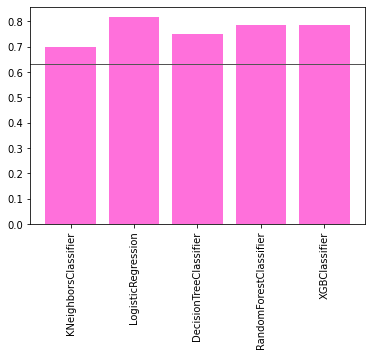

In [51]:
plt.bar([Model.__name__ for Model in candidates], accuracies, color='#ff33cc', alpha=0.7)
plt.axhline(y=0.63, linewidth=1, color='#555555')
plt.xticks(rotation=90);

In [52]:
# all models, above, are better than baseline
# continue to do feature engineering until you are satisfied, then continue with gridsearch

# GridSearch

- perform gridsearch
- use multiple notebooks if necessary to speed this process up!
- [Decision Tree](gridsearch_dt.ipynb)

# Make Final Model

In [96]:
hyperparams = {
        'criterion': 'gini',
        'max_depth': 3,
        'max_features': 'log2',
        'min_samples_split': 3
}
model = DecisionTreeClassifier(**hyperparams).fit(X_train, y_train)

In [97]:
metrics = pd.DataFrame(np.zeros((100,3)), columns=['accuracy', 'precision', 'recall'])
thresholds = range(0, 100)
for t in thresholds:
    y_hat = model.predict_proba(X_test)[:,1] > (t/100)
    metrics.loc[t] = accuracy_score(y_test, y_hat), precision_score(y_test, y_hat, zero_division=0), recall_score(y_test, y_hat, zero_division=0)

<Figure size 864x504 with 1 Axes>

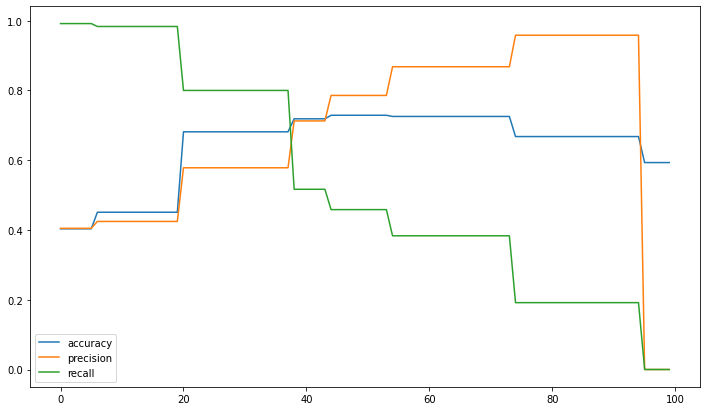

In [98]:
# no reason to change threshold, looks good
metrics.plot(figsize=(12, 7));

# Use Test Data on Final Model

In [99]:
model.score(X_test, y_test)

0.7288135593220338

# Explain the Model and Features

<Figure size 432x288 with 1 Axes>

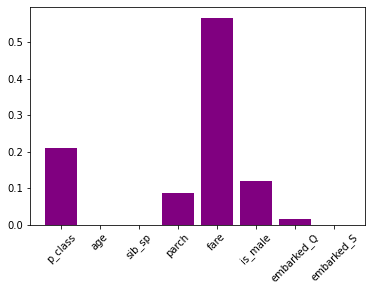

In [107]:
plt.bar(X_test.columns, model.feature_importances_, color='purple')
plt.xticks(rotation=45);

# Pickel Model to use in Production

In [111]:
with open('model.p', 'wb') as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

In [113]:
with open('model.p', 'rb') as file:
    reanimated = pickle.load(file)

In [114]:
reanimated.score(X_test, y_test)

0.7288135593220338

# Finished